# Importing Packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from heapq import nlargest
from flask import Flask, request, jsonify
import requests
%matplotlib inline

# Load Dataset

In [13]:
raw_data = pd.read_csv('okcupid_profiles.csv')

In [14]:
okcupid_profiles = raw_data.iloc[:5002,0:21] # Ignore all the "essay" text columns for now// raw_data.iloc[:10000,0:21]

# Data Cleaning and Analysis

In [15]:
total_nrows = okcupid_profiles.shape[0]
total_ncols = okcupid_profiles.shape[1]
print('Total rows: ', total_nrows, ' Total columns: ', total_ncols)
print(okcupid_profiles.info())

Total rows:  5002  Total columns:  21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5002 entries, 0 to 5001
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          5002 non-null   int64  
 1   status       5002 non-null   object 
 2   sex          5002 non-null   object 
 3   orientation  5002 non-null   object 
 4   body_type    4543 non-null   object 
 5   diet         3037 non-null   object 
 6   drinks       4746 non-null   object 
 7   drugs        3804 non-null   object 
 8   education    4482 non-null   object 
 9   ethnicity    4508 non-null   object 
 10  height       5002 non-null   float64
 11  income       5002 non-null   int64  
 12  job          4304 non-null   object 
 13  last_online  5002 non-null   object 
 14  location     5002 non-null   object 
 15  offspring    2060 non-null   object 
 16  pets         3306 non-null   object 
 17  religion     3296 non-null   object 
 18  sign      

In [16]:
# append IDs as another column
df = okcupid_profiles
df.insert(0, "id", df.index +1001 , True)  # 1001 as starting id
okcupid_profiles.head(2) #display first 2 entries

,id,age,status,sex,orientation,body_type,diet,drinks,drugs,education,...,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks
0,1001,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,...,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english
1,1002,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,...,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (..."


In [17]:
print(okcupid_profiles.isna().sum())
for col in okcupid_profiles.drop(['id', 'age'],axis=1).columns:
    print(f"-----------{col}-----------")
    print(okcupid_profiles[col].nunique())

id                0
age               0
status            0
sex               0
orientation       0
body_type       459
diet           1965
drinks          256
drugs          1198
education       520
ethnicity       494
height            0
income            0
job             698
last_online       0
location          0
offspring      2942
pets           1696
religion       1706
sign            900
smokes          498
speaks            4
dtype: int64
-----------status-----------
4
-----------sex-----------
2
-----------orientation-----------
3
-----------body_type-----------
12
-----------diet-----------
18
-----------drinks-----------
6
-----------drugs-----------
3
-----------education-----------
30
-----------ethnicity-----------
87
-----------height-----------
28
-----------income-----------
13
-----------job-----------
21
-----------last_online-----------
3925
-----------location-----------
73
-----------offspring-----------
15
-----------pets-----------
15
-----------religion------

# Normalizing Features

In [18]:
column = 'age'
okcupid_profiles[column] = (okcupid_profiles[column] - okcupid_profiles[column].min()) / (okcupid_profiles[column].max() - okcupid_profiles[column].min())   
column = 'height'
okcupid_profiles[column] = (okcupid_profiles[column] - okcupid_profiles[column].min()) / (okcupid_profiles[column].max() - okcupid_profiles[column].min())   
okcupid_profiles.head(2)

,id,age,status,sex,orientation,body_type,diet,drinks,drugs,education,...,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks
0,1001,0.043478,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,...,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english
1,1002,0.184783,single,m,straight,average,mostly other,often,sometimes,working on space camp,...,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (..."


# Visualizing Normalized Data using Box Plot

array([0.48717949, 0.35897436, 0.30769231, 0.38461538, 0.25641026,
       0.28205128, 0.23076923, 0.41025641, 0.15384615, 0.20512821,
       0.33333333, 0.43589744, 0.46153846, 0.1025641 , 0.17948718,
       0.51282051, 0.12820513, 0.56410256, 0.58974359, 0.07692308,
       0.61538462, 0.8974359 , 0.69230769, 0.53846154, 0.05128205,
       0.        , 1.        , 0.02564103])

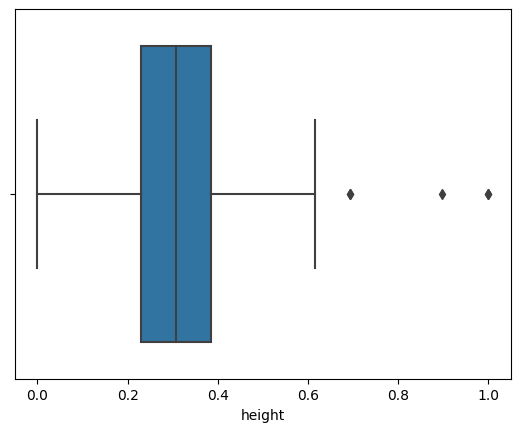

In [19]:
okcupid_profiles[column].describe()
sns.boxplot(x=okcupid_profiles[column])
okcupid_profiles["height"].unique()

# Loading Likes Data

In [20]:
#load likes dataset
likes_data = pd.read_csv('likesdata.csv',index_col=0)

In [21]:
likes_data.head()

,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# For Testing Purpose: Finding the list of liked profiles of an ID

In [22]:
listi = [] #list of liked profiles for some specified id
 
id = 1005 #id to be searched matches for (index)
for i in range(likes_data.shape[1]):
    if likes_data.loc[id][i]==1.0 :
        listi.append(likes_data.columns[i])

liked_list = listi
listi

['1003', '1004', '1050', '1076', '1080']

# One Hot Encoding of Profiles

In [23]:
#one hot encoding ie creates more columns for  1 0 mapping

dummydat2= okcupid_profiles[["id", "age","height", "status", "sex", "drinks", "smokes", "offspring", "drugs", "body_type", "orientation"]]  #CHOOSING ONLY THESE COLUMNS FOR ENCODING
nominal_features = pd.get_dummies(data = dummydat2,columns= ["status", "sex", "drinks", "smokes", "offspring", "drugs", "body_type", "orientation"], drop_first=True)   # ENCODE
nominal_features

,id,age,height,status_married,status_seeing someone,status_single,sex_m,drinks_not at all,drinks_often,drinks_rarely,...,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,orientation_gay,orientation_straight
0,1001,0.043478,0.487179,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1002,0.184783,0.358974,False,False,True,True,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,1003,0.217391,0.307692,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,1004,0.054348,0.384615,False,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,1005,0.119565,0.256410,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4997,5998,0.065217,0.307692,False,False,True,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4998,5999,0.108696,0.282051,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4999,6000,0.086957,0.153846,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
5000,6001,0.260870,0.179487,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Load Output Dataset i.e. for Recommended Profiles

In [24]:
reco_data = pd.read_csv('Reco_data_output.csv',index_col=0)

# Finding Cosine Similarity

In [25]:
def findmatches(curr):  # FUNCTION TO RETURN LIST OF RECO IDS CORRESPONDING TO CURR ID
    Dict = {}

    curterm = nominal_features[nominal_features["id"]==curr]  #PICKOUT THE WHOLE ROW CORESP TO CURR ID
    curterm.drop(labels="id", axis=1)   #remove id COLUMN before cosine similarty

    for t in nominal_features.id:   #ITERATE FOR ALL PROFILES(IDS)
        iterm = nominal_features[nominal_features["id"]==int(t)]  #ROW OF EACH ID
        iterm.drop(labels="id", axis=1)
        Dict[int(t)] = cosine_similarity(curterm,iterm )    #STORE THE KEY-ID AND VALUE-SIMILARITY PAIR IN DICT DICTIONARY
        
        
    best_matches = nlargest(10, Dict, key = Dict.get)       #PICK OUT TOP 3 MATCHES OF CURR AND STORE IN BEST_MATCHES
    return best_matches      # returns best match recommendation to curr


In [26]:
for i in range(1002,1500):   # RANGE TO WHICH RECO IDS ARE TO BE FOUND
    
    id = i #id i to be searched matches for (index)
    matches = []
    
    for p in likes_data.columns: # TO FIND MATCHES OF i ID (likesdata(i,p) = 1 IF MATCH)
        t=int(p)
        if likes_data.loc[id,str(t)]==1.0 :
            matches+=findmatches(t)  # IF A MATCH, FIND SIMILAR PROFILES TO MATCH PROFILE AND APPEND TO MATCHES(RECO MATCHES) LIST
    
    
    for k in matches:
        reco_data.loc[i,str(k)]=1.0   # NOW MAKE CHANGES TO RECO CSV BY PUTTING 1 TO RECO PROFILES FOR EACH i ID ROW 
        

In [27]:
reco_data.head()

,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
reco_data.to_csv('resultrecos.csv',index=True)

In [29]:
matches1005 = reco_data.index[reco_data.loc[1005].notna()==True].to_list() # to print recod profiles for the given id
nominal_features[nominal_features["id"].isin(matches1005)]

,id,age,height,status_married,status_seeing someone,status_single,sex_m,drinks_not at all,drinks_often,drinks_rarely,...,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,orientation_gay,orientation_straight
2,1003,0.217391,0.307692,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,1004,0.054348,0.384615,False,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
49,1050,0.086957,0.256410,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
54,1055,0.163043,0.333333,False,False,True,True,False,False,True,...,True,False,False,False,False,False,False,False,False,True
61,1062,0.184783,0.487179,False,False,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True
71,1072,0.163043,0.282051,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
74,1075,0.108696,0.410256,False,False,True,True,False,False,False,...,True,False,False,False,False,False,False,False,False,True
75,1076,0.119565,0.282051,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
77,1078,0.076087,0.230769,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
79,1080,0.032609,0.384615,False,False,True,True,False,False,True,...,True,False,False,False,False,False,False,False,False,True


In [32]:
similarto1003 = findmatches(1003)  #find similar profs of given id
similarto1003

[1003, 1445, 1483, 1062, 1600, 1662, 1698, 1249, 1824, 1862]

In [37]:
app = Flask(__name__)

@app.route('/', methods=['GET'])
def get():
    return "hello recommender server"

@app.route('/find-matches', methods=['POST'])
def find_matches():
    print(request.json)
    data = request.json
    print(data)
    if 'id' not in data:
        return jsonify({'error': 'ID not provided'}), 400
    
    id = data['id']
    print(id)
    similar_profs = findmatches(id)
    print(similar_profs)
    
    try:
        response = requests.post('http://127.0.0.1:5001/find-matched-users', json={'id': similar_profs, 'curr':id})
        response.raise_for_status()  
        return jsonify(response.json()), response.status_code
    except requests.exceptions.RequestException as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
[2024-05-08 03:53:14,503] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(

{'id': None}
{'id': None}
None


[2024-05-08 03:54:07,059] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': None}
{'id': None}
None


[2024-05-08 03:54:09,676] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': None}
{'id': None}
None


[2024-05-08 03:54:10,789] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': None}
{'id': None}
None
{'id': None}
{'id': None}
None


[2024-05-08 03:54:11,770] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': None}
{'id': None}
None


[2024-05-08 03:54:26,430] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': None}
{'id': None}
None


[2024-05-08 03:54:34,409] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:54:36,888] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:54:44,090] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:44,773] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:45,384] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:45,688] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:45,962] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:46,288] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:46,584] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:46,883] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:47,353] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:47,720] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:48,135] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:55:53,348] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:56:34,740] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:56:35,016] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]
{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:56:35,635] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:56:40,488] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:56:44,868] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '[object Object]'}
{'id': '[object Object]'}
[object Object]


[2024-05-08 03:58:53,317] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '1003'}
{'id': '1003'}
1003


[2024-05-08 03:59:05,938] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '1003'}
{'id': '1003'}
1003


[2024-05-08 03:59:10,430] ERROR in app: Exception on /find-matches [POST]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'id': '1003'}
{'id': '1003'}
1003
{'id': 1003}
{'id': 1003}
1003


127.0.0.1 - - [08/May/2024 03:59:23] "POST /find-matches HTTP/1.1" 200 -


[1003, 1445, 1483, 1062, 1600, 1662, 1698, 1249, 1824, 1862]
